In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import os

# %matplotlib

In [2]:
BASE_PATH = os.path.abspath(os.path.curdir)
PRICE_DATA_DIR = os.path.join(BASE_PATH, "data/price_data/")
MENTIONS_COUNT_DIR = os.path.join(BASE_PATH, "data/date_count")

COLOR_MAIN = "#363A45"
COLOR_MA_5 = "#FF9800"
COLOR_MA_8 = "#E040FB"
COLOR_MA_13 = "#9C27B0"
COLOR_VOLUME = "#B2B5BE"

MIN_DATE = "2021-02-01 00:00:00"
MAX_DATE = "2021-04-05 03:00:00"


TRACKED_COIN = "XRP"

plt.style.use("seaborn")


In [3]:
def date_parser(timestamp):
    return datetime.datetime.fromtimestamp(int(timestamp))


def add_rolling_mean(
    df, attrs: list, intervals: list, group_by=None, min_eq_max=True, min_w=1
):
    df = df.copy()
    for attr in attrs:
        for interval in intervals:
            interval *= 4
            if min_eq_max:
                min_w = interval
            if group_by != None:
                df[f"{attr}_MA_{int(interval/4)}"] = df.groupby(group_by)[
                    attr
                ].transform(lambda x: x.rolling(interval, min_w).mean())
            else:
                df[f"{attr}_MA_{int(interval/4)}"] = df[attr].transform(
                    lambda x: x.rolling(interval, min_w).mean()
                )
    return df

In [4]:
price_data = pd.read_csv(
    open(os.path.join(PRICE_DATA_DIR, TRACKED_COIN, f"{TRACKED_COIN}_price.csv"), "r"),
    parse_dates=True,
    date_parser=date_parser,
    index_col="date",
)

volume_data = pd.read_csv(
    open(os.path.join(PRICE_DATA_DIR, TRACKED_COIN, f"{TRACKED_COIN}_volume.csv"), "r"),
    parse_dates=True,
    date_parser=date_parser,
    index_col="date",
)

mentions_data = pd.read_csv(
    open(os.path.join(MENTIONS_COUNT_DIR, f"{TRACKED_COIN}.csv"), "r"),
    parse_dates=True,
    date_parser=date_parser,
    index_col="date",
)

price_data.info()
volume_data.info()
mentions_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1514 entries, 2021-02-01 00:00:00 to 2021-04-05 02:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   1514 non-null   float64
dtypes: float64(1)
memory usage: 23.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1514 entries, 2021-02-01 00:00:00 to 2021-04-05 02:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  1514 non-null   float64
dtypes: float64(1)
memory usage: 23.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1516 entries, 2021-02-01 00:00:00 to 2021-04-05 03:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   1516 non-null   int64
dtypes: int64(1)
memory usage: 23.7 KB


In [5]:
price_data = add_rolling_mean(price_data, ["price"], [5, 8, 13])
mentions_data = add_rolling_mean(mentions_data, ["count"], [5, 8, 13])

mentions_data

,count,count_MA_5,count_MA_8,count_MA_13
date,,,,
2021-02-01 00:00:00,226,NaN,NaN,NaN
2021-02-01 01:00:00,192,NaN,NaN,NaN
2021-02-01 02:00:00,138,NaN,NaN,NaN
2021-02-01 03:00:00,96,NaN,NaN,NaN
2021-02-01 04:00:00,460,NaN,NaN,NaN
...,...,...,...,...
2021-04-04 23:00:00,0,0.3,0.1875,0.269231
2021-04-05 00:00:00,2,0.4,0.2500,0.307692
2021-04-05 01:00:00,0,0.3,0.2500,0.307692


Text(0.5, 0.98, 'XRP')

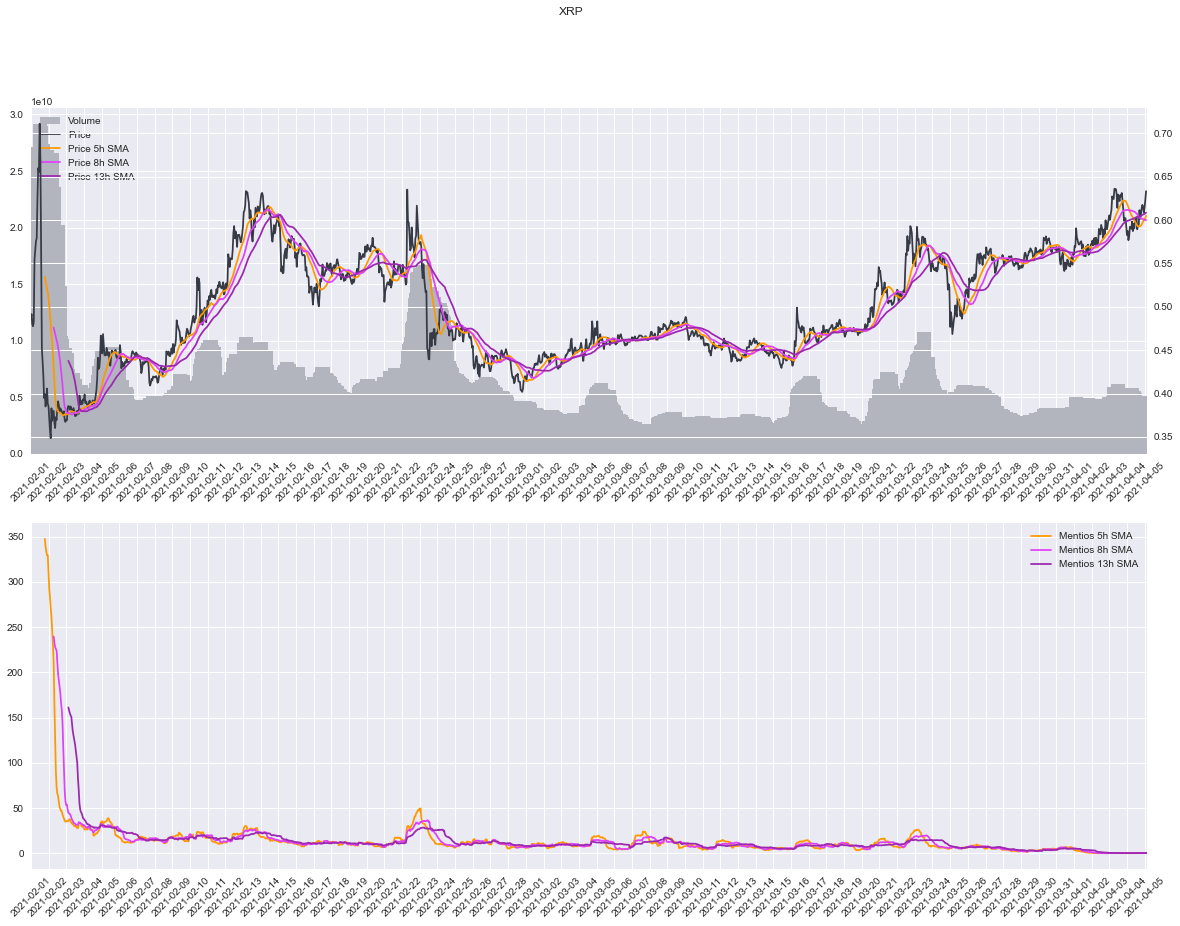

In [6]:
fig, ax1 = plt.subplots(2, 1, figsize=(20, 14))

date_range = pd.date_range(
    start=MIN_DATE,
    end=MAX_DATE,
    freq="D",
)

ax1[0].bar(
    height=volume_data["volume"],
    x=volume_data.index,
    color=COLOR_VOLUME,
    label="Volume",
)

ax2 = ax1[0].twinx()
ax2.plot(price_data["price"], color=COLOR_MAIN, label="Price")
ax2.plot(price_data["price_MA_5"], color=COLOR_MA_5, label="Price 5h SMA")
ax2.plot(price_data["price_MA_8"], color=COLOR_MA_8, label="Price 8h SMA")
ax2.plot(price_data["price_MA_13"], color=COLOR_MA_13, label="Price 13h SMA")

ax1[1].plot(mentions_data["count_MA_5"], color=COLOR_MA_5, label="Mentios 5h SMA")
ax1[1].plot(mentions_data["count_MA_8"], color=COLOR_MA_8, label="Mentios 8h SMA")
ax1[1].plot(mentions_data["count_MA_13"], color=COLOR_MA_13, label="Mentios 13h SMA")

ax1[0].set_xlim(
    [
        datetime.datetime.fromisoformat(MIN_DATE),
        datetime.datetime.fromisoformat(MAX_DATE),
    ]
)

ax1[1].set_xlim(
    [
        datetime.datetime.fromisoformat(MIN_DATE),
        datetime.datetime.fromisoformat(MAX_DATE),
    ]
)

ax1[0].xaxis.set_ticks(date_range)
ax1[0].set_xticklabels(
    [pd.to_datetime(e).date() for e in date_range.values], rotation=45
)

ax1[1].xaxis.set_ticks(date_range)
ax1[1].set_xticklabels(
    [pd.to_datetime(e).date() for e in date_range.values], rotation=45
)

h1, l1 = ax1[0].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1[0].legend(h1 + h2, l1 + l2, loc=2)

ax1[1].legend(loc=0)

fig.suptitle(TRACKED_COIN)


In [7]:
price_data

,price,price_MA_5,price_MA_8,price_MA_13
date,,,,
2021-02-01 00:00:00,0.486716,NaN,NaN,NaN
2021-02-01 01:00:00,0.491648,NaN,NaN,NaN
2021-02-01 02:00:00,0.479747,NaN,NaN,NaN
2021-02-01 03:00:00,0.477578,NaN,NaN,NaN
2021-02-01 04:00:00,0.482367,NaN,NaN,NaN
...,...,...,...,...
2021-04-04 22:00:00,0.614592,0.598597,0.601204,0.606568
2021-04-04 23:00:00,0.608359,0.599963,0.600564,0.606732
2021-04-05 00:00:00,0.614677,0.601086,0.600170,0.607206


In [8]:
mentions_data.loc['2021-02-01 00:00:00']

count          226.0
count_MA_5       NaN
count_MA_8       NaN
count_MA_13      NaN
Name: 2021-02-01 00:00:00, dtype: float64

In [9]:
price_data.index

DatetimeIndex(['2021-02-01 00:00:00', '2021-02-01 01:00:00',
               '2021-02-01 02:00:00', '2021-02-01 03:00:00',
               '2021-02-01 04:00:00', '2021-02-01 05:00:00',
               '2021-02-01 06:00:00', '2021-02-01 07:00:00',
               '2021-02-01 08:00:00', '2021-02-01 09:00:00',
               ...
               '2021-04-04 17:00:00', '2021-04-04 18:00:00',
               '2021-04-04 19:00:00', '2021-04-04 20:00:00',
               '2021-04-04 21:00:00', '2021-04-04 22:00:00',
               '2021-04-04 23:00:00', '2021-04-05 00:00:00',
               '2021-04-05 01:00:00', '2021-04-05 02:00:00'],
              dtype='datetime64[ns]', name='date', length=1514, freq=None)

In [10]:
price_indexes = price_data.index

In [11]:
for index, row in mentions_data.iterrows():
    if index not in price_indexes:
        mentions_data = mentions_data.drop(index)

In [12]:

mentions_data

,count,count_MA_5,count_MA_8,count_MA_13
date,,,,
2021-02-01 00:00:00,226,NaN,NaN,NaN
2021-02-01 01:00:00,192,NaN,NaN,NaN
2021-02-01 02:00:00,138,NaN,NaN,NaN
2021-02-01 03:00:00,96,NaN,NaN,NaN
2021-02-01 04:00:00,460,NaN,NaN,NaN
...,...,...,...,...
2021-04-04 22:00:00,0,0.3,0.1875,0.269231
2021-04-04 23:00:00,0,0.3,0.1875,0.269231
2021-04-05 00:00:00,2,0.4,0.2500,0.307692


In [13]:
from scipy.stats import spearmanr, pearsonr
from scipy import signal

corr, _ = pearsonr(price_data["price"].values, mentions_data["count"].values)
print('Pearsons correlation: %.3f' % corr)
corr, _ = spearmanr(price_data["price"].values, mentions_data["count"].values)
print('Spearmans correlation: %.3f' % corr)

Pearsons correlation: 0.068
Spearmans correlation: -0.201


[143.13769784 262.59607056 346.10070062 ...   0.95949391   0.98329561
   0.97343285]
[-1511 -1510 -1509 ...  1511  1512  1513]
[1.11058352e-02 2.03744278e-02 2.68534245e-02 ... 7.44456664e-05
 7.62924039e-05 7.55271676e-05]


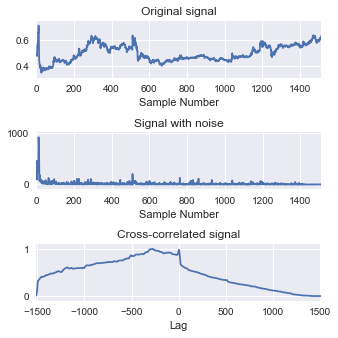

In [14]:
x = np.arange(128) / 128

sig = price_data["price"].values

sig_noise = mentions_data["count"].values[:-2]

corr = signal.correlate(sig_noise, sig)
print(corr)

lags = signal.correlation_lags(len(sig), len(sig_noise))
print(lags)

corr /= np.max(corr)
print(corr)



fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(4.8, 4.8))

ax_orig.plot(sig)

ax_orig.set_title('Original signal')

ax_orig.set_xlabel('Sample Number')

ax_noise.plot(sig_noise)

ax_noise.set_title('Signal with noise')

ax_noise.set_xlabel('Sample Number')

ax_corr.plot(lags, corr)

ax_corr.set_title('Cross-correlated signal')

ax_corr.set_xlabel('Lag')

ax_orig.margins(0, 0.1)

ax_noise.margins(0, 0.1)

ax_corr.margins(0, 0.1)

fig.tight_layout()

plt.show()

In [15]:
trackedC =  pd.read_csv('data/tracked_coins.csv')
trackedC

,symbol
0,ALBT
1,POLKAMON
2,PI
3,DIGIBYTE
4,FNT
...,...
1051,EFX
1052,AMPL
1053,KAN
1054,NEBLIO


In [16]:
ddd = pd.read_csv(
        open(os.path.join(PRICE_DATA_DIR, "ADA", f"ADA_price.csv"), "r"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
ddd

,price
date,
2021-02-01 00:00:00,0.344100
2021-02-01 01:00:00,0.344275
2021-02-01 02:00:00,0.339718
2021-02-01 03:00:00,0.345874
2021-02-01 04:00:00,0.343229
...,...
2021-04-04 22:00:00,1.184852
2021-04-04 23:00:00,1.179842
2021-04-05 00:00:00,1.181285


In [17]:
from scipy import signal

tab = []
for coin in os.listdir(PRICE_DATA_DIR):
    price_data = pd.read_csv(
        open(os.path.join(PRICE_DATA_DIR, coin, f"{coin}_price.csv"), "r"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )

    mentions_data = pd.read_csv(
        open(os.path.join(MENTIONS_COUNT_DIR, f"{coin}.csv"), "r"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    
    for index, _ in mentions_data.iterrows():
        if index not in price_data.index:
            try:
                mentions_data = mentions_data.drop(index)
            except KeyError as e:
                print(e, coin)
                
    try:        
        sig = price_data.values
        sig_noise = mentions_data.values
        corr = signal.correlate(sig_noise, sig)
        corr /= np.max(corr)
        tab.append(corr)
    except ValueError as e:
        print(e, coin)


"[Timestamp('2021-03-28 03:00:00')] not found in axis" CARDS
"[Timestamp('2021-03-28 03:00:00')] not found in axis" ELON
zero-size array to reduction operation maximum which has no identity ELON
"[Timestamp('2021-03-28 03:00:00')] not found in axis" PUNDIX
"[Timestamp('2021-03-28 03:00:00')] not found in axis" ZOOM
zero-size array to reduction operation maximum which has no identity ZOOM


In [18]:
max_predict = []
predict = pd.DataFrame()

for row in zip(tab, os.listdir(PRICE_DATA_DIR)):
    max_predict.append([row[1], sum(row[0][:len(row[0])//2])])
    #predict.loc[-1] = [row[1]] + [sum(row[0][:len(row[0])//2])]
    predict = predict.append([[row[1]] + [sum(row[0][:len(row[0])//2])]], ignore_index=True)
    
max_predict.sort(key=lambda x: x[1], reverse=True)
predict.sort_values(by=[1], ascending=False)

,0,1
140,REN,[1204.8198834468103]
197,ZIL,[1184.3491203821366]
103,MBL,[1119.2318681806205]
190,XRP,[1117.992615965644]
163,TIPS,[1117.7310942537085]
...,...,...
145,RVN,[188.1162966538853]
90,LA,[172.61199018377172]
111,MOD,[162.00067230012118]
134,PROS,[89.23100440081019]
